# 2次元ガウス分布に対する変分推論

参考：https://machine-learning.hatenablog.com/entry/2016/01/31/172500

In [12]:
using Plots
using LinearAlgebra
using Distributions

## パラメータを格納するコンストラクタを作成

In [13]:
struct Gauss
    μ::Vector{Float64}
    Λ::Matrix{Float64}
end

## パラメータの初期化

In [14]:
function init_params(D)
    μ = randn(D)
    Λ = zeros(D, D)
    return Gauss(μ, Λ)
end

init_params (generic function with 1 method)

## パラメータの更新即

In [15]:
function update_params(μ, Λ, mg::Gauss)
    mg.μ[1] = μ[1] - inv(Λ[1, 1]) * Λ[1, 2] * (mg.μ[2] - μ[2])
    mg.Λ[1, 1] = Λ[1, 1]
    mg.μ[2] = μ[2] - inv(Λ[2, 2]) * Λ[2, 1] * (mg.μ[1] - μ[1])
    mg.Λ[2, 2] = Λ[2, 2]
    return mg
end

update_params (generic function with 1 method)

## KL divergenceの計算

In [16]:
function calc_KL(μ, Λ, mg::Gauss)
    D = size(μ, 1)
    qform = tr(((μ - mg.μ) * (μ - mg.μ)' + inv(mg.Λ)) * Λ)
    KL = 0.5 * (qform + logdet(inv(Λ)) - logdet(inv(mg.Λ)) - D)
    return KL
end

calc_KL (generic function with 1 method)

## 変分推論

In [17]:
function learn_VI(D, μ, Λ, maxiter)
    result = Vector()
    KL = Vector{Float64}()
    
    mg = init_params(D)
    for i in 1:maxiter
        mg = update_params(μ, Λ, mg)
        push!(result, (deepcopy(mg.μ), deepcopy(inv(mg.Λ))))
        push!(KL, calc_KL(μ, Λ, mg))
    end
    return result, KL
end

learn_VI (generic function with 1 method)

## メイン

In [18]:
# 次元数を設定
D = 2

# パラメータの初期値を設定
μ = [
    0.0
    0.0
]

θ = 2.0 *　π / 12
A = [
    cos(θ) -sin(θ)
    sin(θ) cos(θ)
]

Λ = inv(A * inv([1.0 0.0; 0.0 10]) * A')

# 推論
maxiter = 10
result, KL = learn_VI(D, μ, Λ, maxiter);

## 可視化

In [19]:
function vialize_2D(μ, Λ, result, KL)
    xs₁ = xs₂ = range(-3, 3, length=100)
    anim = @animate for i in 1:maxiter
        p = contour(xs₁, xs₂, [pdf(MvNormal(μ, inv(Λ)), [x₁, x₂]) for x₁ in xs₁, x₂ in xs₂]')
        d = MvNormal(result[i][1], inv(result[i][2]))
        p = contour!(xs₁, xs₂, [pdf(d, [x₁, x₂]) for x₁ in xs₁, x₂ in xs₂]', xlab="x₁", ylab="x₂", title="$i")
    end
    p1 = gif(anim, "2d_gauss.gif", fps=10)
    
    xs = 1.0:1.0:10.0
    p2 = plot(xs, KL, label=:none, xlab="iteration", ylab="KL divergence")
    
    return p1, p2
end

vialize_2D (generic function with 1 method)

In [20]:
p1, p2 = vialize_2D(μ, Λ, result, KL)

┌ Info: Saved animation to 
│   fn = /Users/akifumiabe/Julia/BayesMLBook/2d_gauss.gif
└ @ Plots /Users/akifumiabe/.julia/packages/Plots/AJMX6/src/animation.jl:114


(Plots.AnimatedGif("/Users/akifumiabe/Julia/BayesMLBook/2d_gauss.gif"), Plot{Plots.GRBackend() n=1})

Plots.AnimatedGif("/Users/akifumiabe/Julia/BayesMLBook/2d_gauss.gif")
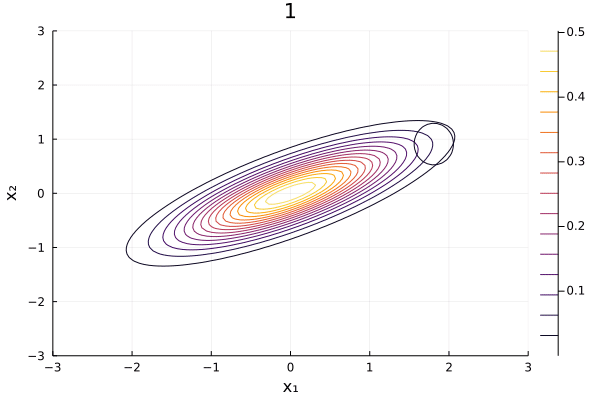

In [21]:
p1

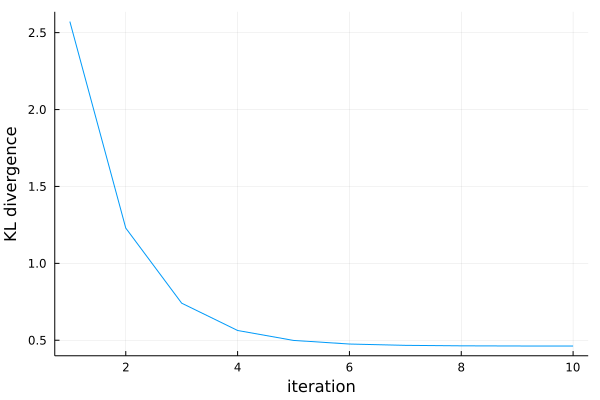

In [22]:
p2